


# HQ Ripper
> * HQ Ripper Starter Kit 1.0a 
* Use with care
* DALL-B is cute and needs cuddles 
She is shy so be nice :) 



---




#### What is this?

This is a notebook that uses DALL-E's decoder and CLIP to generate images from text. I will very likely make this better & easier to use in the future.

Feel free to send correspondence to [@advadnoun](https://twitter.com/advadnoun) on Twitter. If you use this notebook or modify it, please be cool and link back to my twitter. 

If you're feeling generous while your Waluigi (or whatever you choose) loads, you can donate to @rynnn on Venmo :)



---



* Who might use this?
> For memes
> Wallpapers
> .......... IDK 

# How do I use this?

First, type in your description where it says *Insert text here*.


Second, click the 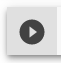 
button that shows up next to the text under the heading **This one!**. The button appears when you move your mouse over the text **This one!** Wait for a bit as it loads and goes in circles, and then move on to the third step when it finishes running.

Third, click on the upper bar at the top of the page where it says **Runtime**, and then click **Restart and run all**. 

Your output will appear at the bottom of this page as it trains after a little while. Scroll down below everything else to see new images appear. The images will start by looking like dirt, but the page will eventually ding and show new images as it begins to attempt to match the image to your description. 

# Choose Text

In [ ]:
text_input = " \" " #@param {type:"string"}


# This one!

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html


# Top


In [ ]:
# don't use half of these lol

import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output



In [ ]:
# were you lucky today?

!nvidia-smi -L


GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-5b9573de-2890-606d-b9c1-682af905fddf)


# Perceptor

In [ ]:


%cd /content/

!git clone https://github.com/openai/CLIP.git


%cd /content/CLIP/

!pip install ftfy

import os
import clip
import torch

clip.available_models()

import numpy as np

# Load the model
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

/content
fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP


['RN50', 'ViT-B/32']

# Params

In [ ]:
# probably don't mess with this unless you're changing generator size
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape


# Define

In [ ]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')
  

# Generator

In [ ]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

!pip install git+https://github.com/openai/DALL-E.git


from dall_e import map_pixels, unmap_pixels, load_model
target_image_size = sideX

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')


  Cloning https://github.com/openai/DALL-E.git to /tmp/pip-req-build-9sou81jd
  Running command git clone -q https://github.com/openai/DALL-E.git /tmp/pip-req-build-9sou81jd
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 21.5MB 1.8MB/s 
     |████████████████████████████████| 1.9MB 36.6MB/s 
     |████████████████████████████████| 143kB 56.8MB/s 
     |████████████████████████████████| 747kB 36.1MB/s 
  Created wheel for DALL-E: filename=DALL_E-0.1-cp37-none-any.whl size=6011 sha256=60c6834286daee72641f4f8fd0145d9cbd5c66049fbe7e5aec298f7100a84eff
  Stored in directory: /tmp/pip-ephem-wheel-cache-t5nudhzg/wheels/e9/f5/e7/efa7ddb4c5899f6e6ffbbd112b8c7a030872274a5cba9ccf04
Successfully built DALL-E
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Fou

NameError: ignored

In [ ]:
# enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", 'cpu')



# x = (torch.zeros(1, 3, 512, 512))


# z_logits = enc(x)
# z = torch.argmax(z_logits, axis=1)
# z = torch.nn.functional.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()


# Latent coordinate

In [ ]:

class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()

        self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())



    def forward(self):

      normu = torch.nn.functional.softmax(self.normu.view(1, 8192, -1), dim=-1).view(1, 8192, 64, 64)


      return normu




lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .1}])
eps = 0



tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()


nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

with torch.no_grad():
  mult = 1
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')
  # print(torch.topk(lats().view(1, 8192, -1), k=3, dim=-1))


# Train

In [ ]:
#@title Look for images below here { vertical-output: true, display-mode: "form" }



def checkin(loss):
  print('''
  ##########################################################
  ''',
        loss, '\n',itt)
  
  with torch.no_grad():
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  # the people spoke and they love "ding"
  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))

  cutn = 64 # improves quality
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .98))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')

  into = nom(into)

  iii = perceptor.encode_image(into)


  llls = lats()
  lat_l = 0



  return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, 1).T.mean(1)]

def train(i):
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  

  
  
  if itt % 100 == 0:
    checkin(loss1)


itt = 0
for asatreat in range(10000):
  train(itt)
  itt+=1



# New Section